# Demonstration by artificial dataset

In [1]:
from fairtorch import ConstraintLoss, DemographicParityLoss, EqualiedOddsLoss
import random
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(2020)

## Prepare artificial dataset 

In [3]:
n_samples = 512
n_feature = 4

def genelate_data(n_samples = n_samples, n_feature=n_feature):

    y = np.random.randint(0, 2, size=n_samples)
    loc0 = np.random.uniform(-1, 1, n_feature)
    loc1 = np.random.uniform(-1, 1, n_feature)

    X = np.zeros((n_samples, n_feature))
    for i, u in enumerate(y):
        if y[i] ==0:
            X[i] = np.random.normal(loc = loc0, scale=1.0, size=n_feature)  
        else:
            X[i] = np.random.normal(loc = loc1, scale=1.0, size=n_feature)  

    sensi_feat = (X[:, 0] > X[:, 0].mean()).astype(int)
    X[:, 0] = sensi_feat.astype(np.float32)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    sensi_feat = torch.from_numpy(sensi_feat)
    return X, y, sensi_feat


In [4]:
dataset = genelate_data(1024)
# data split
n_train = int(0.7*len(dataset[0]))
X_train, y_train, sensi_train = map(lambda x : x[:n_train], dataset)
X_test, y_test, sensi_test = map(lambda x : x[n_train:], dataset)


## vannila model

In [5]:
dim_hiden = 32

model = nn.Sequential(nn.Linear(n_feature,1))


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)


for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

for i in range(0, 50):
    optimizer.zero_grad()    
    logit = model(X_train)
    loss = criterion(logit.view(-1), y_train)
    loss.backward()
    optimizer.step()

acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

print("acc train: ", acc_train)
print("acc test: ",acc_test)

acc_test_vanilla = acc_test

acc train:  0.7346368432044983
acc test:  0.7629870176315308


## parity check

In [6]:
y_pred = (torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()

# expected value of y_pred = 1 for each sensitive group
# E[h(X)|A=a]
# correspond to demographic parity
expect_by_a={}

for i in [0, 1]:
    # print(sensi_test.shape, y_pred.shape)
    idx = sensi_test==i
    expect_by_a[i]=  y_pred[idx].mean().item()
print(expect_by_a)
vanilla_gap_dp = np.abs(expect_by_a[0] - expect_by_a[1])
print("gap: ",vanilla_gap_dp)


# expected value of y_pred = 1 for each sensitive group and true label
# E[h(X)|A=a, Y=y]
# correspond to equalized odds

expect_by_a_y = {}
expect_by_a_y_list = []

for i in [0, 1]:
    expect_by_a_y[i]={}
    for j in [0, 1]:
        idx= (sensi_test == i) & (y_test == j)
        expc = y_pred[idx].mean().item()
        expect_by_a_y[i][j] =  expc
        expect_by_a_y_list.append(expc)
print(expect_by_a_y)
vanilla_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
print("gap: ", vanilla_gap_eo)




{0: 0.8013244867324829, 1: 0.337579607963562}
gap:  0.4637448787689209
{0: {0: 0.4615384638309479, 1: 0.871999979019165}, 1: {0: 0.27131783962249756, 1: 0.6428571343421936}}
gap:  0.6006821393966675


## demographic partity 

In [7]:
model = nn.Sequential(nn.Linear(n_feature,1))
dp_loss = DemographicParityLoss(sensitive_classes=[0, 1], alpha=100)
optimizer = optim.SGD(model.parameters(),lr=0.1)



for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

for i in range(0, 50):
    optimizer.zero_grad()    
    logit = model(X_train)
    loss = criterion(logit.view(-1), y_train)
    loss +=  dp_loss(X_train, logit, sensi_train)
    loss.backward()
    optimizer.step()


acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

print("acc train: ", acc_train)
print("acc test: ",acc_test)
acc_test_dp = acc_test


acc train:  0.6689944267272949
acc test:  0.6461039185523987


In [8]:
y_pred = (torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()

# expected value of y_pred = 1 for each sensitive group
# E[h(X)|A=a]
# correspond to demographic parity
expect_by_a={}

for i in [0, 1]:
    idx = sensi_test==i
    expect_by_a[i]=  y_pred[idx].mean().item()
print(expect_by_a)
dp_gap_dp = np.abs(expect_by_a[0] - expect_by_a[1])
print("gap: ",dp_gap_dp)


{0: 0.748344361782074, 1: 0.5923566818237305}
gap:  0.1559876799583435


In [9]:
print("gap of Expected values of each (sensitive) with vanilla training: {} / total accuracy is {}".format(vanilla_gap_dp, acc_test_vanilla) )
print("gap of Expected values of each (sensitive) with DP-constrained training: {} / total accuracy is {}".format(dp_gap_dp, acc_test_dp) )

gap of Expected values of each (sensitive) with vanilla training: 0.4637448787689209 / total accuracy is 0.7629870176315308
gap of Expected values of each (sensitive) with DP-constrained training: 0.1559876799583435 / total accuracy is 0.6461039185523987


## Equalied Odds 

In [10]:
model = nn.Sequential(nn.Linear(n_feature,1))
dp_loss = EqualiedOddsLoss(sensitive_classes=[0, 1], alpha=1000)
optimizer = optim.SGD(model.parameters(),lr=0.1)



for param in model.parameters():
    nn.init.normal_(param, 0, 1e-7)
model.train()

for i in range(0, 50):
    optimizer.zero_grad()    
    logit = model(X_train)
    loss = criterion(logit.view(-1), y_train)
    loss +=  dp_loss(X_train, logit, sensi_train, y_train)
    loss.backward()
    optimizer.step()


acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

print("acc train: ", acc_train)
print("acc test: ",acc_test)
acc_test_eo = acc_test


acc train:  0.7094972133636475
acc test:  0.7077922224998474


In [11]:
# expected value of y_pred = 1 for each sensitive group and true label
# E[h(X)|A=a, Y=y]
# correspond to equalized odds

expect_by_a_y = {}
expect_by_a_y_list = []

for i in [0, 1]:
    expect_by_a_y[i]={}
    for j in [0, 1]:
        idx= (sensi_test == i) & (y_test == j)
        expc = y_pred[idx].mean().item()
        expect_by_a_y[i][j] =  expc
        expect_by_a_y_list.append(expc)
print(expect_by_a_y)

eo_gap_eo = np.max(expect_by_a_y_list)- np.min(expect_by_a_y_list)
print("gap: ", eo_gap_eo)

{0: {0: 0.42307692766189575, 1: 0.8159999847412109}, 1: {0: 0.5426356792449951, 1: 0.8214285969734192}}
gap:  0.39835166931152344


In [12]:
print("gap of Expected values of each (sensitive, y) with vanilla training: {} / total accuracy is {}".format(vanilla_gap_eo, acc_test_vanilla) )
print("gap of Expected values of each (sensitive, y) with EO-constrained training: {} / total accuracy is {}".format(eo_gap_eo, acc_test_eo) )

gap of Expected values of each (sensitive, y) with vanilla training: 0.6006821393966675 / total accuracy is 0.7629870176315308
gap of Expected values of each (sensitive, y) with EO-constrained training: 0.39835166931152344 / total accuracy is 0.7077922224998474


## Trade-off between fairness and accuracy  

Let's do experiment of trade-off between fairness and accuracy, changing degree of constraint

In [78]:
acc_list = []
dp_fairness_list = []
alpha_list = np.logspace(-2, 2, 20)

for alpha in alpha_list:
    model = nn.Sequential(nn.Linear(n_feature,1))
    dp_loss = DemographicParityLoss(sensitive_classes=[0, 1], alpha=alpha)
    optimizer = optim.Adam(model.parameters())


    for param in model.parameters():
        nn.init.normal_(param, 0, 1e-7)
    model.train()

    for i in range(0, 50):
        optimizer.zero_grad()    
        logit = model(X_train)
        loss = criterion(logit.view(-1), y_train)
        loss +=  dp_loss(X_train, logit, sensi_train)
        loss.backward()
        optimizer.step()


    acc_train = ((torch.sigmoid(model(X_train)).view(-1) > 0.5 ).float()  == y_train ).float().mean().float().item()
    acc_test = ((torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()  == y_test ).float().mean().float().item()

    acc_test_dp = acc_test
    y_pred = (torch.sigmoid(model(X_test)).view(-1) > 0.5 ).float()
    acc_list.append(acc_test_dp)

    expect_by_a={}
    for i in [0, 1]:
        idx = sensi_test==i
        expect_by_a[i]=  y_pred[idx].mean().item()
    dp_gap_dp = np.abs(expect_by_a[0] - expect_by_a[1])
    dp_fairness_list.append(dp_gap_dp)

    



In [79]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'total accuracy')

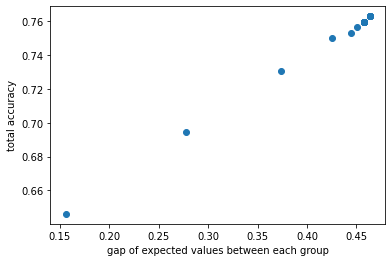

In [81]:
plt.scatter(dp_fairness_list, acc_list)
plt.xlabel("gap of expected values between each group")
plt.ylabel("total accuracy")


Text(0.5, 0, 'alpha (degree of contraint)')

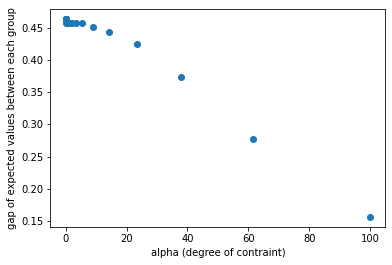

In [82]:
plt.scatter(alpha_list, dp_fairness_list)
plt.ylabel("gap of expected values between each group")
plt.xlabel("alpha (degree of contraint)")
